## Catalog Exploration Simple


A more condensed version from Catalog_Exploration notebook (basic parts are deleted for simplicity)

In [1]:
from obspy import read_events

In [2]:
catalog = read_events("hyp_koeri_2020.out")

/home/ege/miniconda3/envs/dsml/lib/python3.12/site-packages/obspy/io/nordic/utils.py:184: UserWarning: Lines of type I have not been implemented yet, please submit a development request
  warnings.warn("Lines of type %s have not been implemented yet, "


In [3]:
catalog

789 Event(s) in Catalog:
2020-01-01T19:01:54.900000Z | +40.820,  +28.930 | 2.1  ML
2020-01-02T04:57:48.500000Z | +40.635,  +29.132 | 2.0  ML
...
2020-09-29T07:11:43.000000Z | +40.843,  +28.184 | 1.7  ML
2020-09-30T11:17:58.200000Z | +40.532,  +29.245 | 1.4  ML
To see all events call 'print(CatalogObject.__str__(print_all=True))'

In [4]:
events_data = []
for event in catalog:
    origin = event.preferred_origin() or event.origins[0] if event.origins else None
    magnitude = event.preferred_magnitude() or event.magnitudes[0] if event.magnitudes else None
    
    if origin:
        events_data.append({
            'datetime': origin.time.datetime if origin.time else None,
            'latitude': origin.latitude,
            'longitude': origin.longitude,
            'depth': origin.depth / 1000 if origin.depth is not None else None,  # Convert m to km
            'magnitude_type': magnitude.magnitude_type if magnitude else None,
            'magnitude': magnitude.mag if magnitude else None
        })

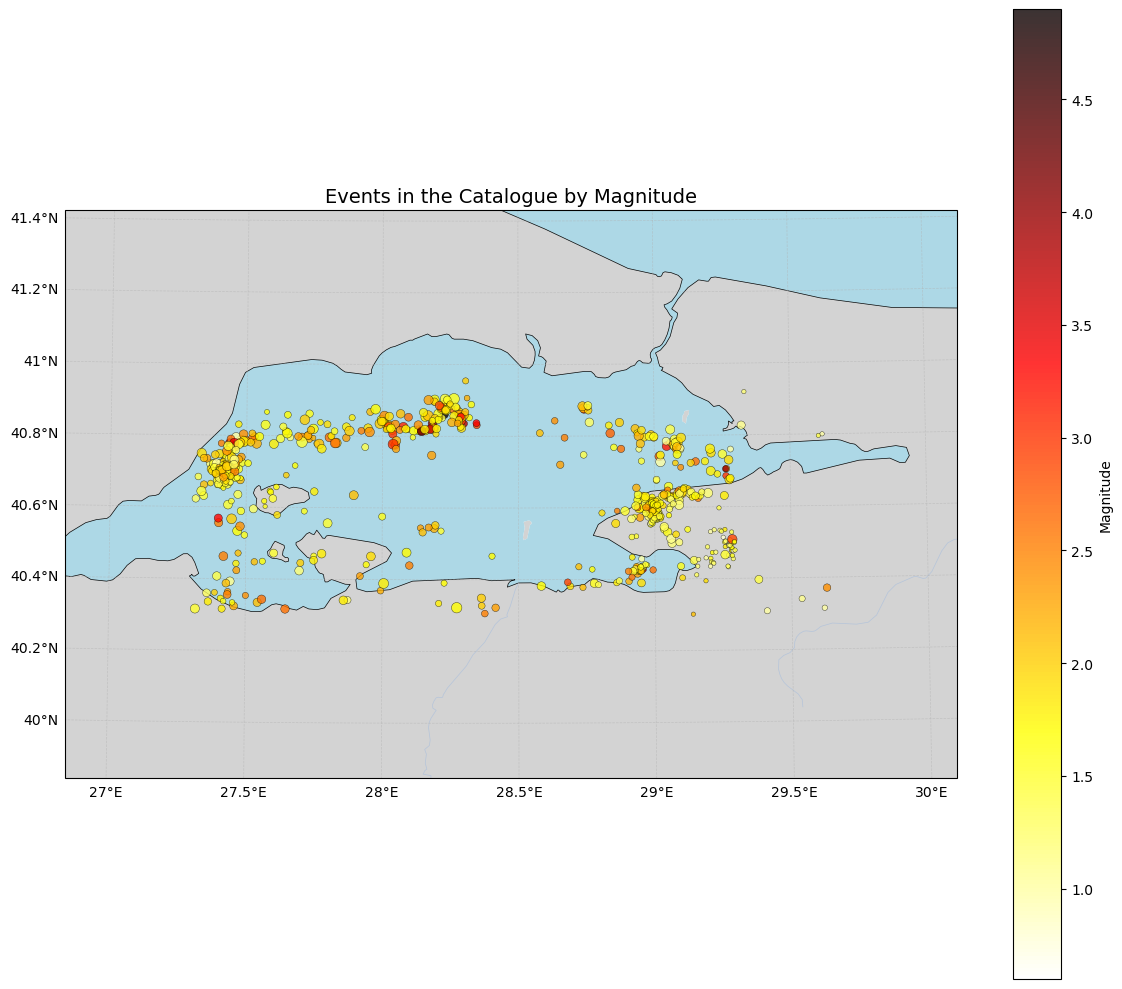

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

fig = plt.figure(figsize=(12, 10))

lats = [event.origins[0].latitude for event in catalog]
lons = [event.origins[0].longitude for event in catalog]

#Create local projection
center_lat = np.mean(lats)
center_lon = np.mean(lons)
projection = ccrs.NearsidePerspective(
    central_longitude=center_lon,
    central_latitude=center_lat,
    satellite_height=3000000.0  #Reduce height for more zoom
)

#Create map axes with the projection
ax = fig.add_subplot(1, 1, 1, projection=projection)

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.5, alpha=0.5)

#Get depths and magnitudes
depths = [event.origins[0].depth/1000 if event.origins[0].depth else 0 for event in catalog]
magnitudes = []
for event in catalog:
    if event.magnitudes:
        magnitudes.append(event.magnitudes[0].mag)
    else:
        magnitudes.append(0)

marker_sizes = [max(10, d * 2 + 10) for d in depths]  # Deeper = larger marker

scatter = ax.scatter(
    lons, lats,
    transform=ccrs.PlateCarree(),  #Input coordinates are lat/lon
    c=magnitudes,
    s=marker_sizes,
    cmap='hot_r',  #Reverse hot colormap: white for low, red/yellow for high
    alpha=0.8,
    zorder=5,
    edgecolor='k',
    linewidth=0.3
)

cbar = plt.colorbar(scatter, ax=ax, pad=0.05)
cbar.set_label('Magnitude')

lat_range = max(lats) - min(lats)
lon_range = max(lons) - min(lons)
padding = max(lat_range, lon_range) * 0.2  #Reduce padding for zoom
ax.set_extent(
    [min(lons) - padding, max(lons) + padding, 
     min(lats) - padding, max(lats) + padding],
    crs=ccrs.PlateCarree()
)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False  

plt.title('Events in the Catalogue by Magnitude', fontsize=14)

plt.tight_layout()
plt.show()

In [6]:
#Uncomment to create the files
#from catalog2csv import cat2csv
#input_file = "hyp_koeri_2020.out"  
#events_output = "earthquake_events.csv"
#stations_output = "station_arrivals.csv"

#cat2csv(input_file, events_output, stations_output)

In [3]:
import pandas as pd
events_df = pd.read_csv("earthquake_events.csv",parse_dates=['datetime'])
events_df

,datetime,latitude,longitude,depth,magnitude_type,magnitude
0,2020-01-01 19:01:54.900,40.8197,28.9303,13.1,ML,2.1
1,2020-01-02 04:57:48.500,40.6353,29.1317,7.0,ML,2.0
2,2020-01-02 11:18:40.900,40.8308,28.3470,7.5,ML,2.9
3,2020-01-02 18:58:53.200,40.7002,29.2073,16.4,ML,1.8
4,2020-01-03 00:39:11.700,40.8820,28.2262,10.0,ML,1.6
...,...,...,...,...,...,...
784,2020-09-27 00:58:42.300,40.8212,28.1990,12.0,ML,1.8
785,2020-09-27 22:54:36.200,40.5463,27.4783,14.5,ML,2.4
786,2020-09-29 04:52:59.400,40.7453,27.3847,10.7,ML,2.0
787,2020-09-29 07:11:43.000,40.8432,28.1837,6.5,ML,1.7


In [4]:
arrival_df = pd.read_csv("station_arrivals.csv",parse_dates=['datetime', 'arrival_time'])
arrival_df

,datetime,station_name,phase,arrival_time,amplitude,period
0,2020-01-01 19:01:54.900,BRGA,IAML,2020-01-01 19:01:58.800,8.600000e-09,NaN
1,2020-01-01 19:01:54.900,HYBA,IAML,2020-01-01 19:01:58.800,8.600000e-09,NaN
2,2020-01-01 19:01:54.900,BUYA,IAML,2020-01-01 19:01:59.100,8.600000e-09,NaN
3,2020-01-01 19:01:54.900,TUZL,IAML,2020-01-01 19:02:00.600,8.600000e-09,NaN
4,2020-01-01 19:01:54.900,ARMT,IAML,2020-01-01 19:02:00.900,8.600000e-09,NaN
...,...,...,...,...,...,...
14605,2020-09-29 07:11:43.000,YAYO,IAML,2020-09-29 07:12:10.800,1.000000e-10,NaN
14606,2020-09-30 11:17:58.200,GEML,IAML,2020-09-30 11:17:59.900,1.400000e-09,NaN
14607,2020-09-30 11:17:58.200,ARMT,IAML,2020-09-30 11:18:04.900,1.400000e-09,NaN
14608,2020-09-30 11:17:58.200,SUSR,IAML,2020-09-30 11:18:19.900,1.400000e-09,NaN


## Statistics for Station and Date Selection Process

Since our catalog encompasses a large date range, I want to look at some statistics to determine a good time interval for waveforms and stations. 

/home/ege/rawcovar/catalog_implementation/catalog_stats.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['period_start'] = df_filtered['datetime'].dt.to_period(period).apply(lambda r: r.start_time)


Event Frequency Analysis (Magnitude >= 1.0, W Period):

Top 10 Most Active Periods:
   period_start  event_count  mean_magnitude  max_magnitude
36   2020-09-07           80        1.868750            4.6
1    2020-01-06           72        1.652778            4.9
48   2020-11-30           51        1.656863            3.3
47   2020-11-23           49        1.746939            3.0
49   2020-12-07           32        1.806250            3.1
46   2020-11-16           31        1.970968            3.5
50   2020-12-14           27        1.840741            2.8
43   2020-10-26           22        1.522727            2.3
42   2020-10-19           19        1.752632            2.8
41   2020-10-12           19        1.784211            3.2

Top Active Period:
period_start      2020-09-07 00:00:00
event_count                        80
mean_magnitude                1.86875
max_magnitude                     4.6
Name: 36, dtype: object


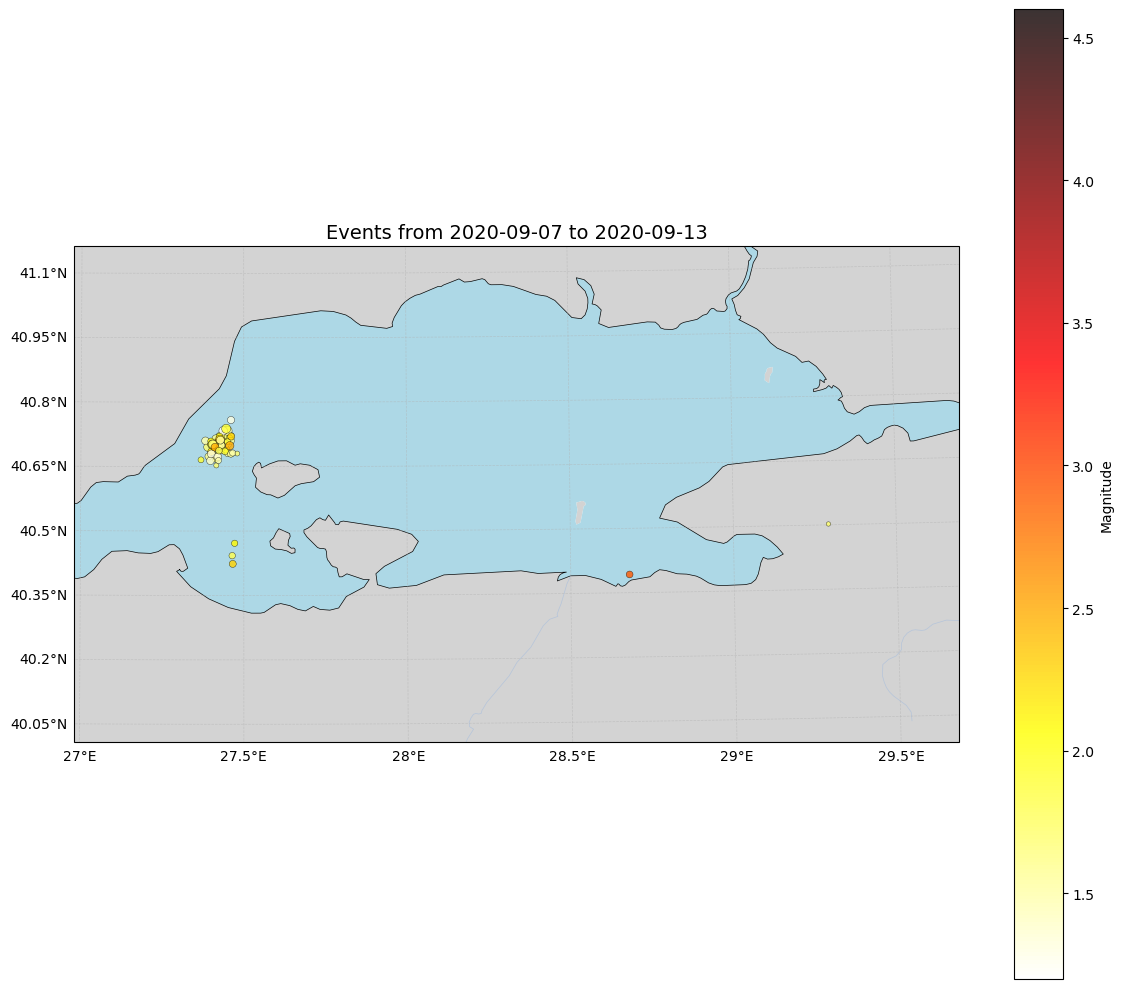


Station Arrival Analysis for Top Period:

Top 10 Stations by Number of Arrivals:
  station_name  arrival_count
0         GAZK             77
1         KRBG             77
2         MRMT             73
3          EDC             71
4          RKY             61
5         ERIK             59
6         BIGA             57
7         CANM             57
8         GELI             55
9          ALN             54

Top 10 Stations Magnitude Coverage:
   station_name  count  min  max      mean
42         KRBG     77  1.2  4.6  1.884416
24         GAZK     77  1.2  4.6  1.868831
44         MRMT     73  1.2  4.6  1.873973
17          EDC     71  1.2  4.6  1.912676
48          RKY     61  1.2  4.6  1.934426
20         ERIK     59  1.2  4.6  1.945763
6          BIGA     57  1.4  4.6  1.987719
10         CANM     57  1.2  4.6  1.957895
25         GELI     55  1.2  4.6  1.967273
1           ALN     54  1.2  4.6  1.935185


In [5]:
from catalog_stats import filtered_cat_summary
filtered_cat_summary(event_df=events_df, station_df=arrival_df, min_mag=1.0, prd="W")

Good candidate for monthly period: 12-2020 

Stations: 

GEML, MDNY, YLV, ARMT

Best candidate for weekly period start: 07-09-2020

Top 5 stations: KRBG, GAZK, MRMT, EDC, RKY